# Lung Disease Diagnosis - Model Tuning

Developer: Tung Nguyen

This notebook contains preliminary classification models for the [lung disease diagnosis dataset](https://www.kaggle.com/datasets/nih-chest-xrays/data).

## Metric Selection
---

The perfect classifier will have zero False Negatives (FN) or False Positives (FP). However, in reality, this is extremely hard to achieve. There are always trade-offs. 

In this case, it is assumed that both False Negatives (FN) and False Positives (FP) have equal weight due to a lack of a use-case for this model. If this were a real deployment, then information about how this model would be used in production could be leveraged to help make modeling and metrics decisions.

* For example, one can argue that FN should be more important than FP in this scenario (e.g. Goal: Minimize FNs) because that would exclude a patient from a treatment that they definitely need. They would be sent home thinking they are healthy. 

* On the other hand, one can argue that FP should be more important than FN because a FP (e.g. Goal: Minimize FPs) because this could potentially cause the patient to purchase and undergo treatment that they did not need. This would waste resources (if the medicine required is rare) as well as cause an undue financial burden on the patient (if the medicine is expensive).

Two popular metrics used to evaluate classification models are the Receiver Operating Characteristics (ROC) Curve and the Precision-Recall (PR) Curve.

The ROC Curve is a plot of the True Positive Rate vs. False Positive Rate of the model for different classification thresholds. Similarly, the PR Curve is a plot of the Precision vs. Recall of the model for different classification thresholds. The area under these curves provide a convenient summary of the model's performance, and allows us to assess the model without having to make a decision on the classification threshold during the training phase (Area = 1 is a perfect classifier). A classification threshold can be chosen at a later stage of the project and can be selected such that the resulting model meets the business-use case (e.g. For the given target True Positive Rate, can you deal with the associated False Positive Rate?).

During the data exploration phase, it was also noted that there is a class imbalance problem present in this dataset. Namely, there are significantly more chest x-ray images with ground truth negative (e.g. no disease present) than there are ground truth positive. This may cause a problem with using the Area Under the ROC Curve (AUROC) as the evaluation metric because calculation of the ROC curve involves True Negatives (e.g. False Positive Rate = FP / (FP + TN)). Since there are large amounts of ground truth negatives in the dataset, AUROC may indicate the model is performing better than it really is. 

Thus, for this project, the Area under the Precision-Recall curve will be the primary model evaluation metric.

## Model Architecture
---



The baseline model for this project will be a VGG16 model, pre-trained on ImageNet images, with a  binary cross entropy loss and the first few layers frozen (set to untrainable). 

Due to time and resource constraints, hyperparameter tuning for this project will be performed on a subset of the dataset.

Models 2 - 8 will experiment with different hyperparameters & configurations to see which have the largest impact. The experiments are detailed in the table below & include things such as:

* Training from scratch vs. fine-tuning

* Data Sampling / Augmentation to combat class imbalance - sample unrepresented classes with transformation (flip, zoom, shifts, etc.)

* No blocks frozen vs. blocks frozen

* Flattening vs. GlobalAvgPooling

* Weighted loss function to combat class imbalance, refer to this [example](https://stackoverflow.com/questions/48485870/multi-label-classification-with-class-weights-in-keras). 

<br>
<br>

__MODEL SUMMARY TABLE__
|  | 1 - Baseline | 2 | 3 | 4 | 5 | 6 | 7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Loss | BCE | BCE | BCE | BCE | BCE | Weighted BCE | Weighted BCE |
| Base Model | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 |
| Model Weights | ImageNet | Untrained | ImageNet | ImageNet | ImageNet | ImageNet | ImageNet |
| Data Sampling | Random | Random | Stratified Sampling | Random | Random | Random | Random |
| Blocks Frozen | 1-3 | None | 1-3 | None | 1-3 | 1-3 | None |
| Pooling Operation | Flatten | Flatten | Flatten | Flatten | GlobalAvg2D | Flatten | Flatten |

* BCE = Binary Cross Entropy

## Data Prep
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow import cast, float32

from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [2]:
df = pd.read_csv('../chest-x-ray-data/Data_Entry_2017.csv')
df = df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=False)

mlb = MultiLabelBinarizer()
lbl_bins = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_bin = df.join(pd.DataFrame(lbl_bins, columns=mlb.classes_))

with open('../chest-x-ray-data/train_val_list.txt', 'r') as f:
    train_list = f.read().split('\n')

with open('../chest-x-ray-data/test_list.txt', 'r') as f:
    test_list = f.read().split('\n')

df_train = df_bin[df_bin['Image Index'].isin(train_list)]
df_test = df_bin[df_bin['Image Index'].isin(test_list)]

In [3]:
def plot_df_freq(df, labels, title=''):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');
    ax.bar_label(ax.containers[0])
    
    return df_pos

### Data Sampling

In [4]:
# Random Sampling
sampled_df_train = df_train.sample(20000, random_state=1)

In [5]:
# Stratified Sampling for Data Augmentation
stratified_sampled_train_df = pd.DataFrame([])

n = 1500

# Sample each label
for lbl in mlb.classes_:
    temp = df_train[df_train[lbl] == 1].sample(
        n,
        replace=True,
        random_state=1
    )
    
    stratified_sampled_train_df = pd.concat([stratified_sampled_train_df, temp])

In [6]:
# Random Oversampling - Method courtesy of https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b
oversampled_df_train = sampled_df_train.copy(deep=True)
powercount = {}
powerlabels = np.unique(oversampled_df_train['Finding Labels'])
for p in powerlabels:
    powercount[p] = np.count_nonzero(oversampled_df_train['Finding Labels']==p)

maxcount = np.max(list(powercount.values()))
for p in powerlabels:
    gapnum = maxcount - powercount[p]
    temp_df = sampled_df_train.iloc[np.random.choice(np.where(sampled_df_train['Finding Labels']==p)[0],size=gapnum)]
    oversampled_df_train = oversampled_df_train.append(temp_df, ignore_index=True)

oversampled_df_train.shape

<ipython-input-6-b9a3ea793f5f>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oversampled_df_train = oversampled_df_train.append(temp_df, ignore_index=True)


(3953924, 22)

__Observations__

* Due to the amount of unique combinations of labels, random oversampling is not a feasible approach for this dataset.

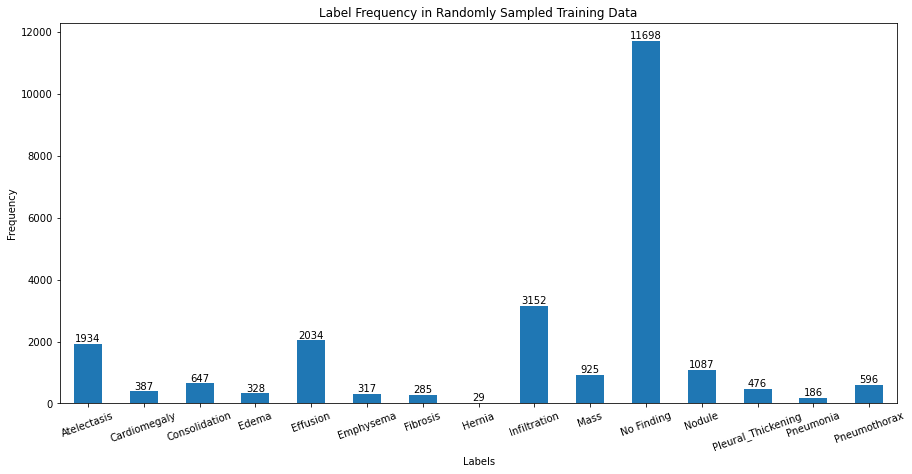

In [7]:
plot_df_freq(sampled_df_train, mlb.classes_, title='Label Frequency in Randomly Sampled Training Data');

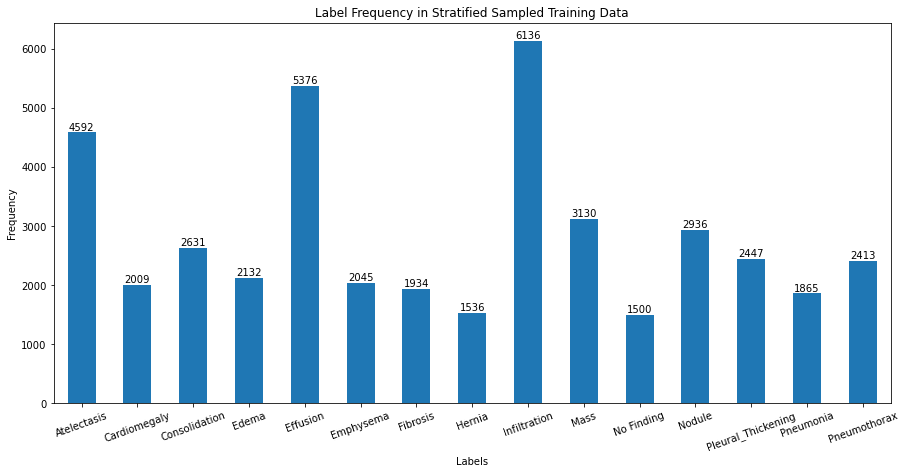

In [8]:
plot_df_freq(stratified_sampled_train_df, mlb.classes_, title='Label Frequency in Stratified Sampled Training Data');

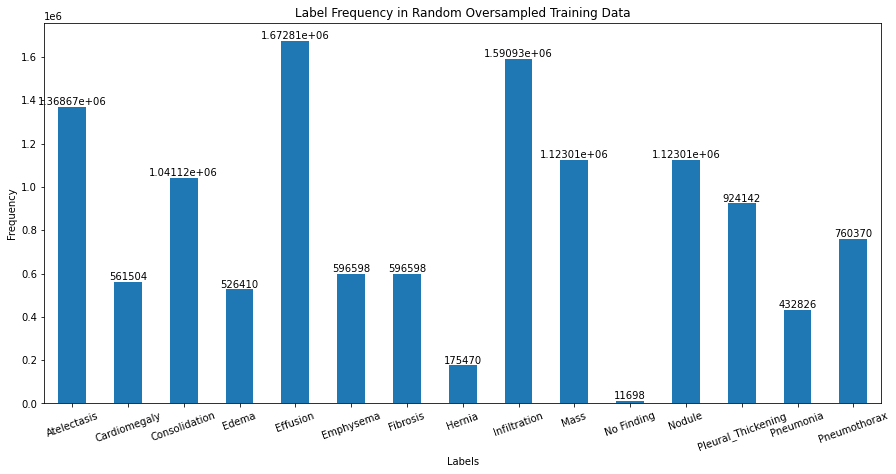

In [9]:
plot_df_freq(oversampled_df_train, mlb.classes_, title='Label Frequency in Random Oversampled Training Data');

### Weighted Loss

In [10]:
labels = [lbl for lbl in mlb.classes_ if lbl != 'No Finding']

In [11]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=sampled_df_train[lbl]))))
    
# Class Weights
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1])
    neg = np.append(neg, d[0])

In [12]:
def get_weighted_loss(pos, neg):
    def weighted_loss(y_true, y_pred):
        y_true = cast(y_true, float32)
        loss = K.mean((neg**(1-y_true))*(pos**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
        return loss
    return weighted_loss

### Helper Functions

In [13]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

In [14]:
def datagen_from_df(train_df, x_col, y_cols, data_dir, preproc_func=None, target_size=(256, 256), val_split=0.2, batch_size=64, color_mode='rgb', random_state=1):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        validation_split=val_split,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
    )

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_dir,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='training',
        seed=random_state
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_dir,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation',
        seed=random_state
    )
    
    return train_generator, validation_generator

In [15]:
# Base Models
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

untrained_base_model = VGG16(
    include_top=False,
    weights=None,
    input_shape=(256, 256, 3)
)

# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.00001
)

chkpt = {}    
base_path = './models/'

for i in np.arange(1, 9):

    chkpt[i] = ModelCheckpoint(
        base_path + 'model-' + str(i) + '.h5', 
        monitor='val_loss',
        verbose=1, 
        save_best_only=True, 
        mode='min', 
    )

## Models
---

### DataGenerators

In [16]:
data_dir = '../chest-x-ray-data/imgs/'

In [17]:
train_gen = {}
val_gen = {}
for i in np.arange(1, 8):
    train_gen[i], val_gen[i] = datagen_from_df(
        sampled_df_train, 
        x_col = 'Image Index', 
        y_cols = labels, 
        data_dir = data_dir, 
        preproc_func = preprocess_input, 
        target_size = (256, 256), 
        val_split = 0.2, 
        batch_size = 64, 
        color_mode = 'rgb', 
        random_state = 1
        )

# Model 3 is the only one which uses stratified sampling df - overwrite
train_gen[3], val_gen[3] = datagen_from_df(
    stratified_sampled_train_df, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input, 
    target_size = (256, 256), 
    val_split = 0.2, 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 18000 validated image filenames.
Found 4500 validated image filenames.


### Model 1 - Baseline

In [18]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [19]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [20]:
history_1 = model.fit(
    train_gen[1], 
    validation_data=val_gen[1],
    epochs = 40,
    callbacks = [chkpt[1], early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.3116 - auc: 0.0481 - auc_1: 0.5223
Epoch 1: val_loss improved from inf to 0.16177, saving model to ./models/model-1.h5
250/250 [==============================] - 329s 1s/step - loss: 0.3116 - auc: 0.0481 - auc_1: 0.5223 - val_loss: 0.1618 - val_auc: 0.0595 - val_auc_1: 0.5697 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.1618 - auc: 0.0581 - auc_1: 0.5703
Epoch 2: val_loss did not improve from 0.16177
250/250 [==============================] - 326s 1s/step - loss: 0.1618 - auc: 0.0581 - auc_1: 0.5703 - val_loss: 0.1706 - val_auc: 0.0563 - val_auc_1: 0.5521 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.1584 - auc: 0.0684 - auc_1: 0.6035
Epoch 3: val_loss improved from 0.16177 to 0.15456, saving model to ./models/model-1.h5
250/250 [==============================] - 319s 1s/step - loss: 0.1584 - auc: 0.0684 - auc_1: 0.6035 - val_loss: 0.154

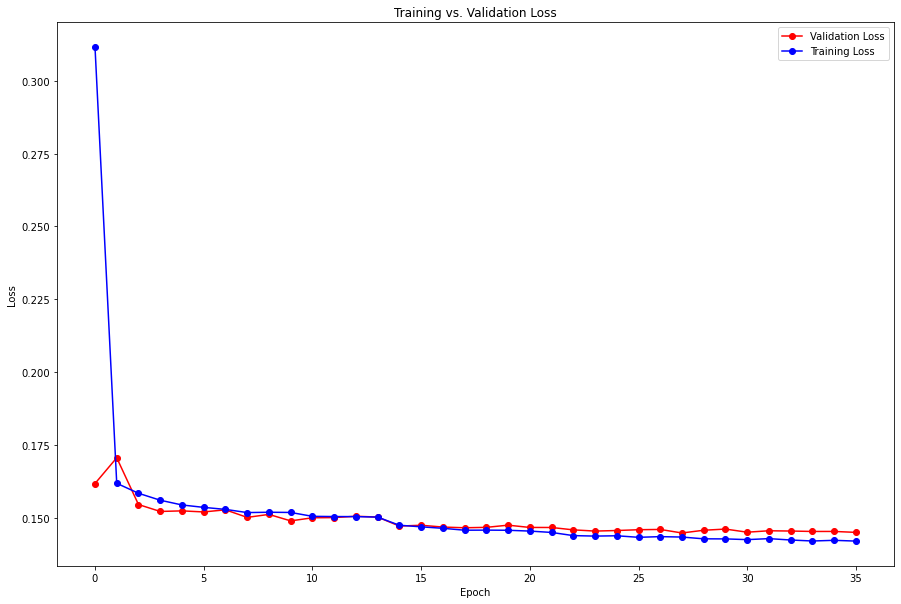

In [21]:
plot_losses(history_1)

### Model 2

In [22]:
model = Sequential()

for layer in untrained_base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [23]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [24]:
history_2 = model.fit(
    train_gen[2], 
    validation_data=val_gen[2],
    epochs = 40,
    callbacks = [chkpt[2], early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.4389 - auc_2: 0.0446 - auc_3: 0.4997
Epoch 1: val_loss improved from inf to 0.16345, saving model to ./models/model-2.h5
250/250 [==============================] - 430s 2s/step - loss: 0.4389 - auc_2: 0.0446 - auc_3: 0.4997 - val_loss: 0.1635 - val_auc_2: 0.0526 - val_auc_3: 0.5354 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.1628 - auc_2: 0.0511 - auc_3: 0.5354
Epoch 2: val_loss improved from 0.16345 to 0.15913, saving model to ./models/model-2.h5
250/250 [==============================] - 428s 2s/step - loss: 0.1628 - auc_2: 0.0511 - auc_3: 0.5354 - val_loss: 0.1591 - val_auc_2: 0.0604 - val_auc_3: 0.5706 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.1622 - auc_2: 0.0546 - auc_3: 0.5473
Epoch 3: val_loss did not improve from 0.15913
250/250 [==============================] - 428s 2s/step - loss: 0.1622 - auc_2: 0.0546 - auc_3: 0.5473 -

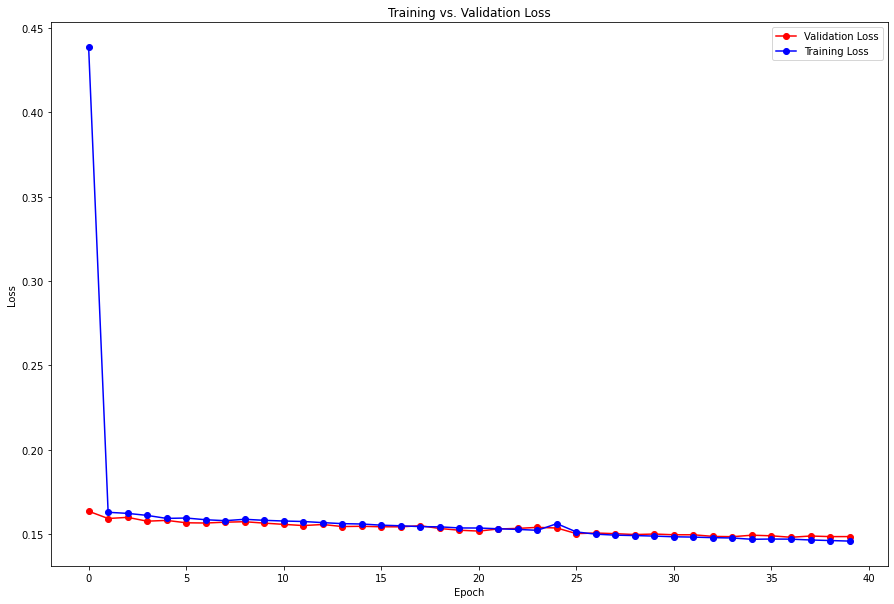

In [25]:
plot_losses(history_2)

### Model 3

In [26]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [27]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [28]:
history_3 = model.fit(
    train_gen[3], 
    validation_data=val_gen[3],
    epochs = 40,
    callbacks = [chkpt[3], early, reduce_lr]
)

Epoch 1/40
282/282 [==============================] - ETA: 0s - loss: 0.3503 - auc_4: 0.2041 - auc_5: 0.6383
Epoch 1: val_loss improved from inf to 0.43539, saving model to ./models/model-3.h5
282/282 [==============================] - 350s 1s/step - loss: 0.3503 - auc_4: 0.2041 - auc_5: 0.6383 - val_loss: 0.4354 - val_auc_4: 0.2058 - val_auc_5: 0.6540 - lr: 0.0010
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 0.3383 - auc_4: 0.2420 - auc_5: 0.6769
Epoch 2: val_loss did not improve from 0.43539
282/282 [==============================] - 342s 1s/step - loss: 0.3383 - auc_4: 0.2420 - auc_5: 0.6769 - val_loss: 0.4394 - val_auc_4: 0.2301 - val_auc_5: 0.6478 - lr: 0.0010
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 0.3322 - auc_4: 0.2669 - auc_5: 0.6929
Epoch 3: val_loss did not improve from 0.43539
282/282 [==============================] - 342s 1s/step - loss: 0.3322 - auc_4: 0.2669 - auc_5: 0.6929 - val_loss: 0.4449 - val_auc_4: 0.2382 - v

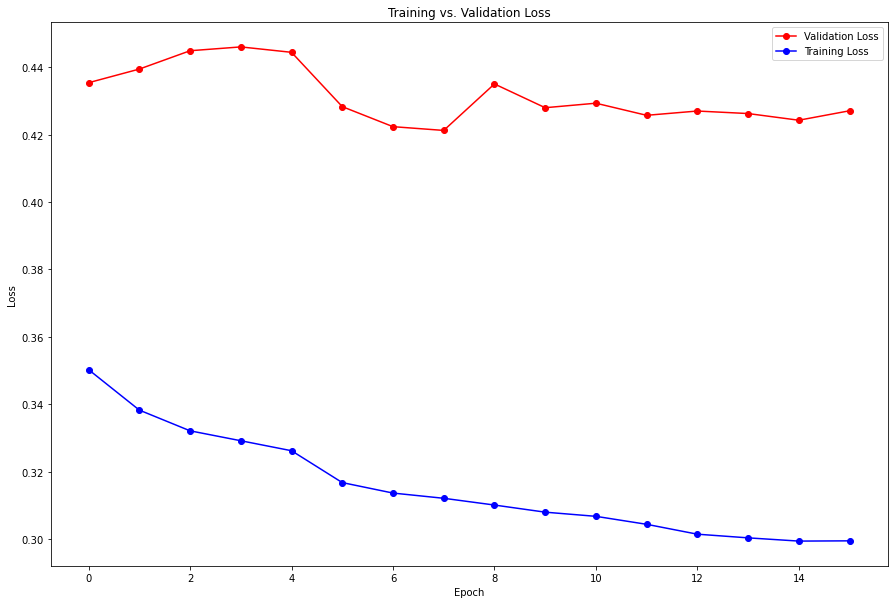

In [29]:
plot_losses(history_3)

### Model 4

In [30]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [31]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [32]:
history_4 = model.fit(
    train_gen[4], 
    validation_data=val_gen[4],
    epochs = 40,
    callbacks = [chkpt[4], early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.1708 - auc_6: 0.0544 - auc_7: 0.5517
Epoch 1: val_loss improved from inf to 0.16042, saving model to ./models/model-4.h5
250/250 [==============================] - 437s 2s/step - loss: 0.1708 - auc_6: 0.0544 - auc_7: 0.5517 - val_loss: 0.1604 - val_auc_6: 0.0659 - val_auc_7: 0.5964 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.1590 - auc_6: 0.0681 - auc_7: 0.5986
Epoch 2: val_loss improved from 0.16042 to 0.15800, saving model to ./models/model-4.h5
250/250 [==============================] - 428s 2s/step - loss: 0.1590 - auc_6: 0.0681 - auc_7: 0.5986 - val_loss: 0.1580 - val_auc_6: 0.0682 - val_auc_7: 0.6058 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.1577 - auc_6: 0.0712 - auc_7: 0.6102
Epoch 3: val_loss improved from 0.15800 to 0.15658, saving model to ./models/model-4.h5
250/250 [==============================] - 428s 2s/step - loss:

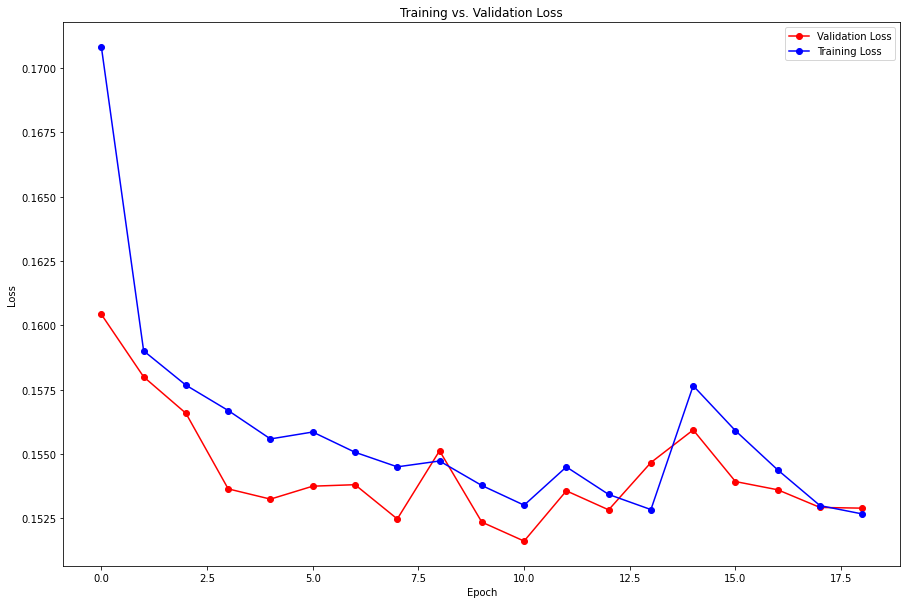

In [33]:
plot_losses(history_4)

### Model 5

In [34]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(GlobalAveragePooling2D())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [35]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [36]:
history_5 = model.fit(
    train_gen[5], 
    validation_data=val_gen[5],
    epochs = 40,
    callbacks = [chkpt[5], early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.2130 - auc_8: 0.0502 - auc_9: 0.5392
Epoch 1: val_loss improved from inf to 0.16524, saving model to ./models/model-5.h5
250/250 [==============================] - 317s 1s/step - loss: 0.2130 - auc_8: 0.0502 - auc_9: 0.5392 - val_loss: 0.1652 - val_auc_8: 0.0598 - val_auc_9: 0.5589 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.1629 - auc_8: 0.0594 - auc_9: 0.5721
Epoch 2: val_loss improved from 0.16524 to 0.15685, saving model to ./models/model-5.h5
250/250 [==============================] - 314s 1s/step - loss: 0.1629 - auc_8: 0.0594 - auc_9: 0.5721 - val_loss: 0.1568 - val_auc_8: 0.0647 - val_auc_9: 0.5945 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.1580 - auc_8: 0.0680 - auc_9: 0.6087
Epoch 3: val_loss improved from 0.15685 to 0.15569, saving model to ./models/model-5.h5
250/250 [==============================] - 316s 1s/step - loss:

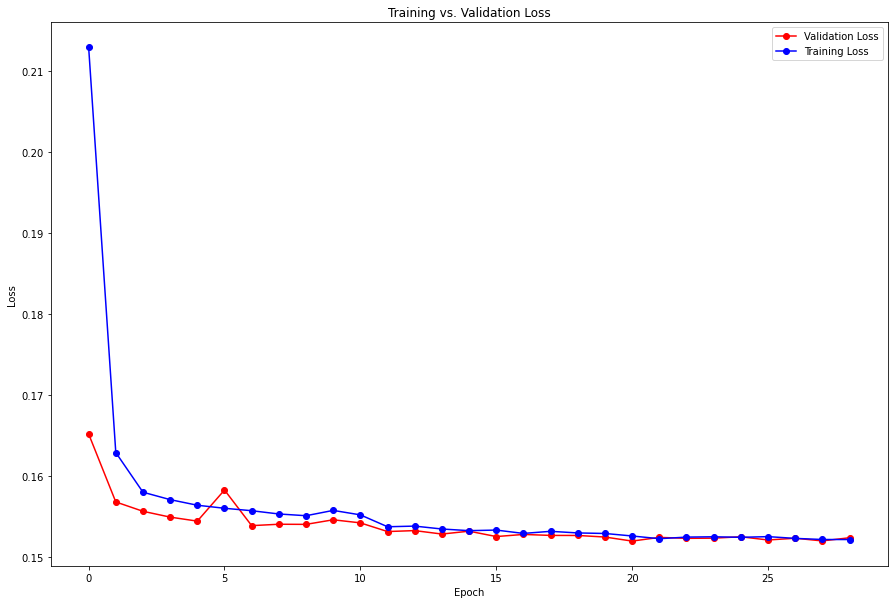

In [37]:
plot_losses(history_5)

### Model 6

In [38]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [39]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [40]:
history_6 = model.fit(
    train_gen[6], 
    validation_data=val_gen[6],
    epochs = 40,
    callbacks = [chkpt[6], early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.7106 - auc_10: 0.0485 - auc_11: 0.5176
Epoch 1: val_loss improved from inf to 0.68742, saving model to ./models/model-6.h5
250/250 [==============================] - 323s 1s/step - loss: 0.7106 - auc_10: 0.0485 - auc_11: 0.5176 - val_loss: 0.6874 - val_auc_10: 0.0444 - val_auc_11: 0.4984 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.7017 - auc_10: 0.0474 - auc_11: 0.5080
Epoch 2: val_loss improved from 0.68742 to 0.68742, saving model to ./models/model-6.h5
250/250 [==============================] - 322s 1s/step - loss: 0.7017 - auc_10: 0.0474 - auc_11: 0.5080 - val_loss: 0.6874 - val_auc_10: 0.0460 - val_auc_11: 0.5123 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.6946 - auc_10: 0.0436 - auc_11: 0.4898
Epoch 3: val_loss did not improve from 0.68742
250/250 [==============================] - 321s 1s/step - loss: 0.6946 - auc_10: 0.0436 - 

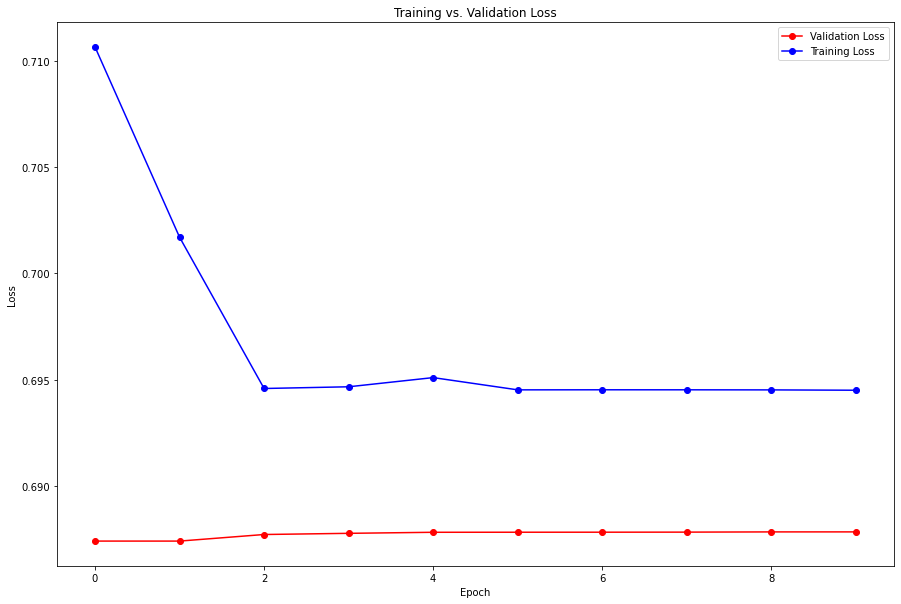

In [41]:
plot_losses(history_6)

### Model 7

In [42]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [43]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg),
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [44]:
history_7 = model.fit(
    train_gen[7], 
    validation_data=val_gen[7],
    epochs = 40,
    callbacks = [chkpt[7], early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.6946 - auc_12: 0.0437 - auc_13: 0.4915
Epoch 1: val_loss improved from inf to 0.68774, saving model to ./models/model-7.h5
250/250 [==============================] - 437s 2s/step - loss: 0.6946 - auc_12: 0.0437 - auc_13: 0.4915 - val_loss: 0.6877 - val_auc_12: 0.0439 - val_auc_13: 0.5000 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.6946 - auc_12: 0.0435 - auc_13: 0.4903
Epoch 2: val_loss did not improve from 0.68774
250/250 [==============================] - 427s 2s/step - loss: 0.6946 - auc_12: 0.0435 - auc_13: 0.4903 - val_loss: 0.6878 - val_auc_12: 0.0439 - val_auc_13: 0.5000 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.6946 - auc_12: 0.0438 - auc_13: 0.4921
Epoch 3: val_loss did not improve from 0.68774
250/250 [==============================] - 427s 2s/step - loss: 0.6946 - auc_12: 0.0438 - auc_13: 0.4921 - val_loss: 0.6878 - val_a

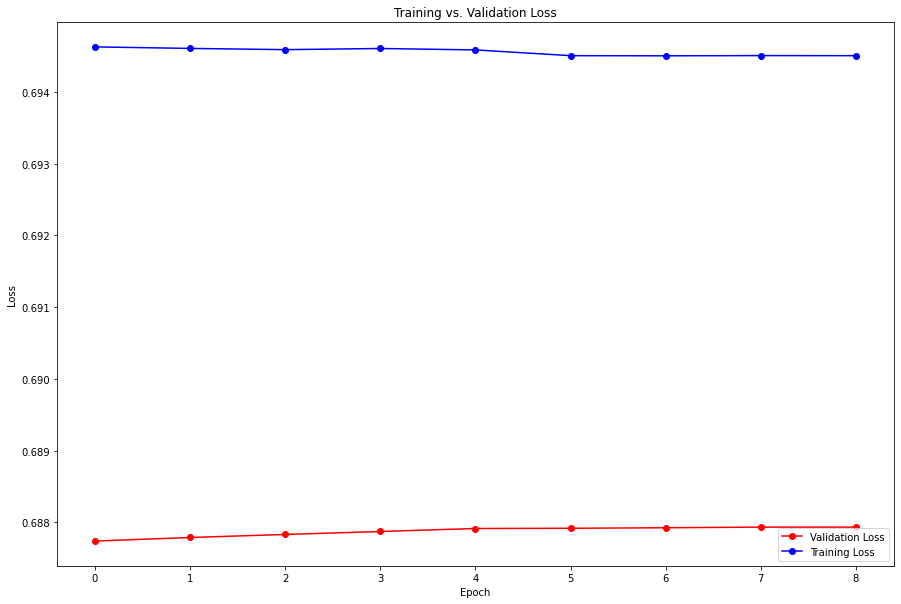

In [45]:
plot_losses(history_7)

## Model Evaluation
---

In [46]:
import csv
from tensorflow.keras.models import load_model

In [47]:
def plot_roc_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):
    
    csv_writer.writerow(['label', 'fpr', 'tpr', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(fpr), fpr, tpr, thresholds))

    ax.legend()
    ax.set_title('ROC Curves - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

def plot_precision_recall_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):

    csv_writer.writerow(['pr', 'rc', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(rc, pr)
        ax.plot(rc, pr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(pr), pr, rc, thresholds))

    ax.legend()
    ax.set_title('Precision-Recall Curve - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

In [49]:
for i in np.arange(1, 8):
    model_name = 'model-' + str(i)

    roc_jpg = './results/roc-' + model_name + '.jpg'
    roc_csv = './results/roc-' + model_name + '.csv'
    auroc_csv = './results/auroc-' + model_name + '.csv'
    pr_jpg = './results/pr-' + model_name + '.jpg'
    pr_csv = './results/pr-' + model_name + '.csv'
    aupr_csv= './results/aupr-' + model_name + '.csv'
    
    model = load_model('./models/' + model_name + '.h5', compile=False)

    val_gen[i].reset()
    y_true = val_gen[i].labels
    y_pred = model.predict(val_gen[i], batch_size=64, verbose=True)

    with open(roc_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_roc_auc(y_true, y_pred, labels, model_name, roc_jpg, csv_writer, figsize=(15, 10))
    
    with open(auroc_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

    with open(pr_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_precision_recall_auc(y_true, y_pred, labels, model_name, pr_jpg, csv_writer, figsize=(15, 10))

    with open(aupr_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

63/63 [==============================] - 64s 1s/step


For reference, the model summary table from the beginning of the notebook is copied below.

<br>

__MODEL SUMMARY TABLE__
|  | 1 - Baseline | 2 | 3 | 4 | 5 | 6 | 7 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Loss | BCE | BCE | BCE | BCE | BCE | Weighted BCE | Weighted BCE |
| Base Model | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 | VGG16 |
| Model Weights | ImageNet | Untrained | ImageNet | ImageNet | ImageNet | ImageNet | ImageNet |
| Data Sampling | Random | Random | Stratified Sampling | Random | Random | Random | Random |
| Blocks Frozen | 1-3 | None | 1-3 | None | 1-3 | 1-3 | None |
| Pooling Operation | Flatten | Flatten | Flatten | Flatten | GlobalAvg2D | Flatten | Flatten |

* BCE = Binary Cross Entropy

### Area Under ROC Curve

In [50]:
import os

def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

results_dir = r'./results/'
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'auroc' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption('SUMMARY - Area Under ROC Curve')

File,auroc-model-1.csv,auroc-model-2.csv,auroc-model-3.csv,auroc-model-4.csv,auroc-model-5.csv,auroc-model-6.csv,auroc-model-7.csv
Atelectasis,0.752333,0.736653,0.647367,0.713750,0.681353,0.518910,0.500000
Cardiomegaly,0.731853,0.783306,0.591033,0.628695,0.616452,0.542399,0.500000
Consolidation,0.740801,0.720601,0.650577,0.740889,0.720067,0.605539,0.500000
Edema,0.824379,0.804931,0.806614,0.789509,0.779801,0.574827,0.500000
Effusion,0.839141,0.808570,0.722434,0.768978,0.752141,0.542303,0.500000
Emphysema,0.719543,0.660986,0.729231,0.664020,0.613166,0.545603,0.500000
Fibrosis,0.691720,0.712819,0.705724,0.549813,0.705212,0.489448,0.500000
Hernia,0.540231,0.691317,0.994824,0.663447,0.779006,0.385818,0.500000
Infiltration,0.654226,0.635198,0.652229,0.633213,0.643404,0.523285,0.500000
Mass,0.690715,0.696463,0.653588,0.643679,0.653829,0.514894,0.500000


__Observations__

* Green-colored cell = best performing model for the given label

* Red-colored cell = worst performing model for the given label

* As shown in the dataframe above, all models (6 & 7) with the weighted loss did not perform very well. In model-7, which has uninitiated weights, the model does not seem to be learning. Thus, the models with weighted loss will be removed from this analysis.

In [51]:
weighted_loss_files = ['auroc-model-' + str(x) + '.csv' for x in np.arange(6, 8)]
df_drop = df.drop(weighted_loss_files, axis=1)
df_drop.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption('SUMMARY - Area Under ROC Curve')

File,auroc-model-1.csv,auroc-model-2.csv,auroc-model-3.csv,auroc-model-4.csv,auroc-model-5.csv
Atelectasis,0.752333,0.736653,0.647367,0.713750,0.681353
Cardiomegaly,0.731853,0.783306,0.591033,0.628695,0.616452
Consolidation,0.740801,0.720601,0.650577,0.740889,0.720067
Edema,0.824379,0.804931,0.806614,0.789509,0.779801
Effusion,0.839141,0.808570,0.722434,0.768978,0.752141
Emphysema,0.719543,0.660986,0.729231,0.664020,0.613166
Fibrosis,0.691720,0.712819,0.705724,0.549813,0.705212
Hernia,0.540231,0.691317,0.994824,0.663447,0.779006
Infiltration,0.654226,0.635198,0.652229,0.633213,0.643404
Mass,0.690715,0.696463,0.653588,0.643679,0.653829


In [52]:
print('Average AUROC:')
for ind, col in df_drop.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUROC:
auroc-model-1.csv: 0.709791
auroc-model-2.csv: 0.707345
auroc-model-3.csv: 0.693630
auroc-model-4.csv: 0.673133
auroc-model-5.csv: 0.677062


__Observations__

* The baseline model has the highest amount of green cells (e.g. best performing for alot of labels), however, it performed especially bad on Hernia, which is one of the underrepresented classes.

* model-3 performed the best on Hernia due to the sampling method used (e.g. class imbalance is resolved using data sampling with replacement). However, it did not seem to perform well on the other classes. The perfect model would be a combination of model-1 and model-3.

* The models all averaged around an AUROC of ~0.7, which does not seem that bad, however, as discussed above, AUROC is overly optimistic for the problem at hand due to the inclusion of FNs in the calculation.

* The ROC Curves for model 1 & model 3 are shown below.

![image](./results/roc-model-1.jpg)

![image](./results/roc-model-3.jpg)

### Area Under PR Curve

In [53]:
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'aupr' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()

weighted_loss_files = ['aupr-model-' + str(x) + '.csv' for x in np.arange(6, 8)]
df_drop = df.drop(weighted_loss_files, axis=1)

df_drop.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption("SUMMARY - Area Under PR Curve")

File,aupr-model-1.csv,aupr-model-2.csv,aupr-model-3.csv,aupr-model-4.csv,aupr-model-5.csv
Atelectasis,0.241769,0.219056,0.593453,0.196551,0.160970
Cardiomegaly,0.121912,0.083295,0.403079,0.027343,0.024691
Consolidation,0.078691,0.069192,0.505240,0.071730,0.059760
Edema,0.071581,0.054304,0.086074,0.058722,0.039678
Effusion,0.412831,0.356548,0.527459,0.269705,0.243774
Emphysema,0.043023,0.030434,0.071030,0.026224,0.019355
Fibrosis,0.054005,0.043654,0.043671,0.025440,0.034366
Hernia,0.002525,0.011539,0.667950,0.004202,0.005791
Infiltration,0.255910,0.239972,0.358832,0.238469,0.242751
Mass,0.096895,0.108129,0.146961,0.075032,0.101453


In [54]:
print('Average AUPR:')
for ind, col in df_drop.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUPR:
aupr-model-1.csv: 0.118693
aupr-model-2.csv: 0.102312
aupr-model-3.csv: 0.262950
aupr-model-4.csv: 0.086216
aupr-model-5.csv: 0.079770


__Observations__

* The AUPR shows a much less optimistic evaluation of the models, with most models hovering around an average AUPR = 0.1

* model-3 is the best performing model, both in terms of number of green cells and on average.

* model-3 is the baseline model with data sampling with replacement. As expected, this method of oversampling improved the AUPR the most for the underrepresented classes -- example: Hernia (AUPR = 0.66 for model-3, AUPR < 0.01 for all other models)

* The PR Curve for model-3 is shown below.

![image](./results/pr-model-3.jpg)